# This notebook shows how to fit a linear resonator in the shunt-coupled configuration.

In [1]:
from __future__ import division, absolute_import, print_function
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from resonator import background, see, shunt

Create data using the model plus gaussian noise. The model is the product of the shunt resonator model and a background model, which in this case has a tilt in magnitude and a typical value of the cable delay.

In [2]:
# Background parameters
background_model = background.MagnitudeSlopeOffsetPhaseDelay()
magnitude_slope = -3e-8
magnitude_offset = 0.1
phase = np.pi / 3
delay = 80e-9  # frequency is in Hz, so this is in s

# Foreground parameters
foreground_model = shunt.LinearShunt()
resonance_frequency = 1e9
internal_loss = 1e-5  # Q_i = 100 000
coupling_loss = 5e-5  # Q_c = 20 000
asymmetry = 0.2  # causes rotation and expansion of the resonance circle due to impedance mismatch or parasitic coupling

# Create an array of measurement frequencies
linewidth = resonance_frequency * (internal_loss + coupling_loss)
frequency = np.linspace(resonance_frequency - 10 * linewidth, resonance_frequency + 10 * linewidth, 501)

# Create the data by evaluating the model functions with the given parameters
bg = background_model.func(frequency=frequency, frequency_reference=frequency.mean(), magnitude_slope=magnitude_slope, magnitude_offset=magnitude_offset, phase=phase, delay=delay)
fg = foreground_model.func(frequency=frequency, resonance_frequency=resonance_frequency, internal_loss=internal_loss, coupling_loss=coupling_loss, asymmetry=asymmetry)

# The ideal data is the product of the background and foreground, and we add some noise to this.
data = bg * fg + 0.02 * magnitude_offset * (np.random.randn(frequency.size) + 1j * np.random.randn(frequency.size)) 

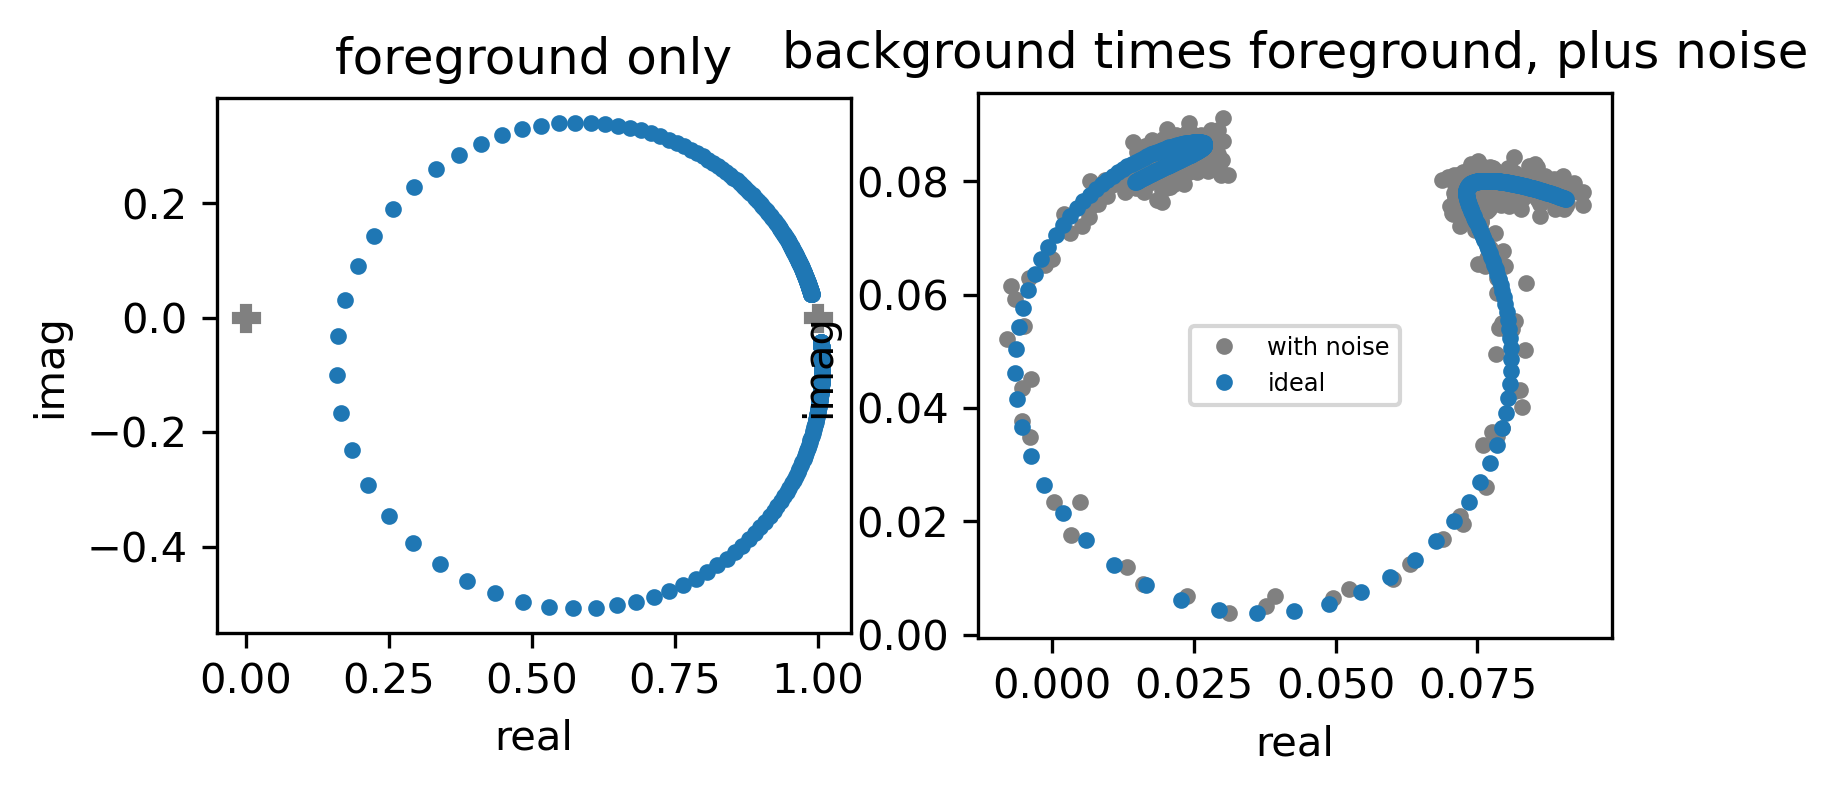

In [3]:
fig, (ax_fg, ax_bgfg) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)

ax_fg.set_aspect('equal')
ax_fg.set_xlabel('real')
ax_fg.set_ylabel('imag')
ax_fg.plot(fg.real, fg.imag, '.')
ax_fg.plot([0, 1], [0, 0], marker='P', linestyle='none', color='gray')
ax_fg.set_title('foreground only')

ax_bgfg.set_aspect('equal')
ax_bgfg.set_xlabel('real')
ax_bgfg.set_ylabel('imag')
ax_bgfg.plot(data.real, data.imag, '.', color='gray', label='with noise')
ax_bgfg.plot((bg * fg).real, (bg * fg).imag, '.', label='ideal')
ax_bgfg.legend(fontsize='xx-small')
ax_bgfg.set_title('background times foreground, plus noise');

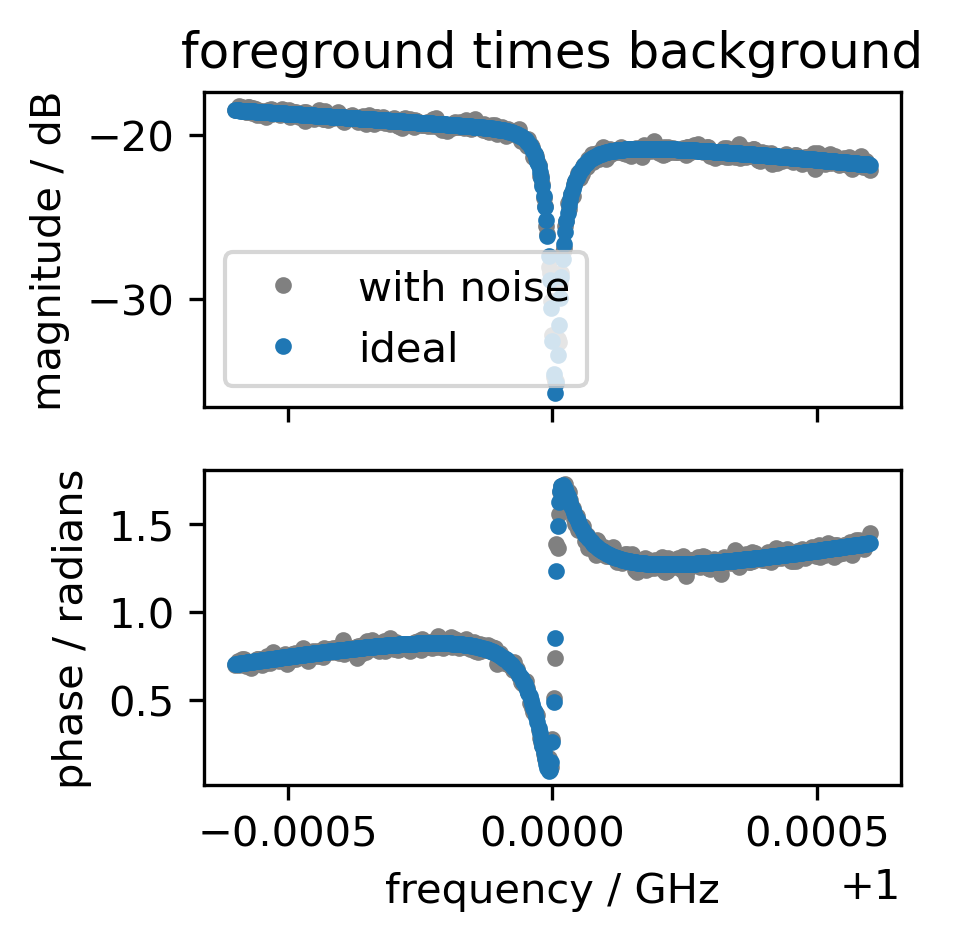

In [4]:
fig, (ax_mag, ax_phase) = plt.subplots(2, 1, sharex=True, figsize=(3, 3), dpi=300)

ax_mag.set_ylabel('magnitude / dB')
ax_mag.plot(1e-9 * frequency, 20 * np.log10(np.abs(data)), '.', color='gray', label='with noise')
ax_mag.plot(1e-9 * frequency, 20 * np.log10(np.abs(bg * fg)), '.', label='ideal')
ax_mag.set_title('foreground times background')
ax_mag.legend()

ax_phase.set_xlabel('frequency / GHz')
ax_phase.set_ylabel('phase / radians')
ax_phase.plot(1e-9 * frequency, np.angle(data), '.', color='gray', label='with noise')
ax_phase.plot(1e-9 * frequency, np.angle(bg * fg), '.', label='ideal');

## Fit the model to the data using a LinearShuntFitter.

The default background model for this fitter (`background.MagnitudePhase`) would not work well here because the background has too much structure. This model has a large number of free parameters, and should be used only when the background really has a tilt in magnitude because simpler backgrounds are more likely to fit successfully.

In [5]:
resonator = shunt.LinearShuntFitter(frequency=frequency, data=data,
                              background_model=background.MagnitudeSlopeOffsetPhaseDelay())
print(resonator.result.fit_report())  # result is a lmfit.model.ModelResult object

[[Model]]
    (Model(magnitude_slope_offset_phase_delay) * Model(linear_shunt))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 37
    # data points      = 1002
    # variables        = 8
    chi-square         = 0.00396012
    reduced chi-square = 3.9840e-06
    Akaike info crit   = -12450.1162
    Bayesian info crit = -12410.8382
    R-squared          = np.complex128(0.9999659416705187+0.00016909636156467266j)
[[Variables]]
    frequency_reference:  1e+09 (fixed)
    magnitude_slope:     -3.0009e-08 +/- 2.8296e-10 (0.94%) (init = -3.378846e-08)
    magnitude_offset:     0.09996521 +/- 9.7396e-05 (0.10%) (init = 0.09847715)
    phase:                1.04712909 +/- 9.9309e-04 (0.09%) (init = 1.036685)
    delay:                8.0149e-08 +/- 4.5565e-10 (0.57%) (init = 1.084769e-07)
    resonance_frequency:  1.0000e+09 +/- 253.904115 (0.00%) (init = 1.000001e+09)
    coupling_loss:        4.9989e-05 +/- 3.1710e-07 (0.63%) (init = 3.62886e-05)
    internal_l

## Plot the data

Use the `see.py` fitting module to plot the data, model, and resonance. These functions create a new figure and axes by default, but can also be used to plot data on existing axes, as shown below.

Note that the normalized (resonator plane) data forms a circle in the complex plane even though the raw data has a more complicated shape due to the background.

C:\Users\Amine Selmani\AppData\Local\Temp\ipykernel_32208\223770844.py:6: UserWarning: Mismatched number of handles and labels: len(handles) = 5 len(labels) = 3
  ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');


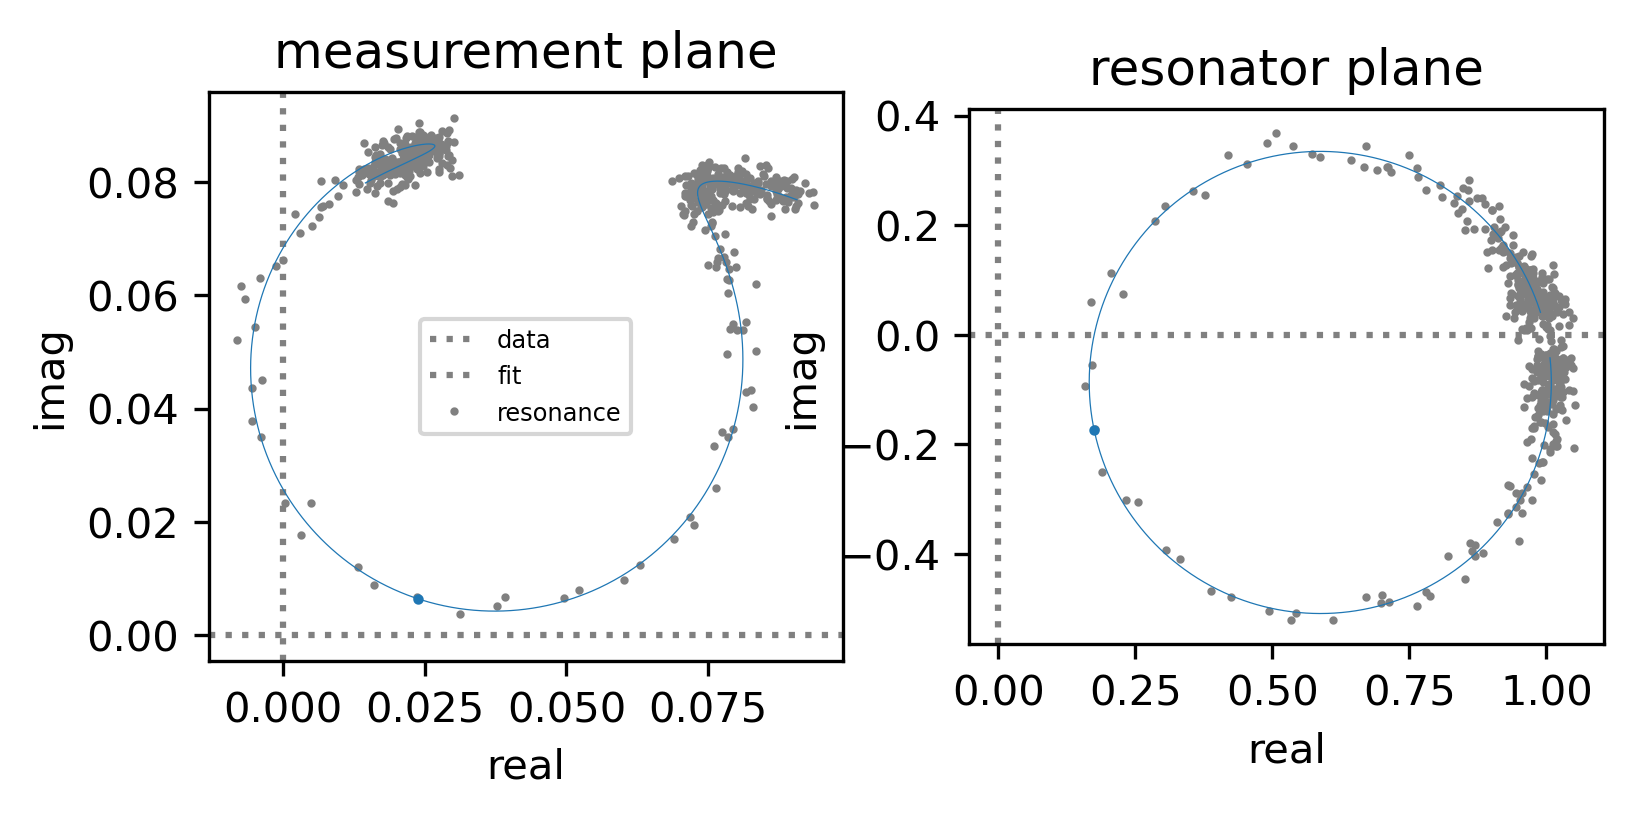

In [6]:
fig, (ax_raw, ax_norm) = plt.subplots(1, 2, figsize=(6, 3), dpi=300)  # Adjust these values for your plot settings
ax_raw.set_title('measurement plane')
ax_norm.set_title('resonator plane')
see.real_and_imaginary(resonator=resonator, axes=ax_raw, normalize=False)
see.real_and_imaginary(resonator=resonator, axes=ax_norm, normalize=True)
ax_raw.legend(handles=ax_raw.lines, labels=('data', 'fit', 'resonance'), fontsize='xx-small');

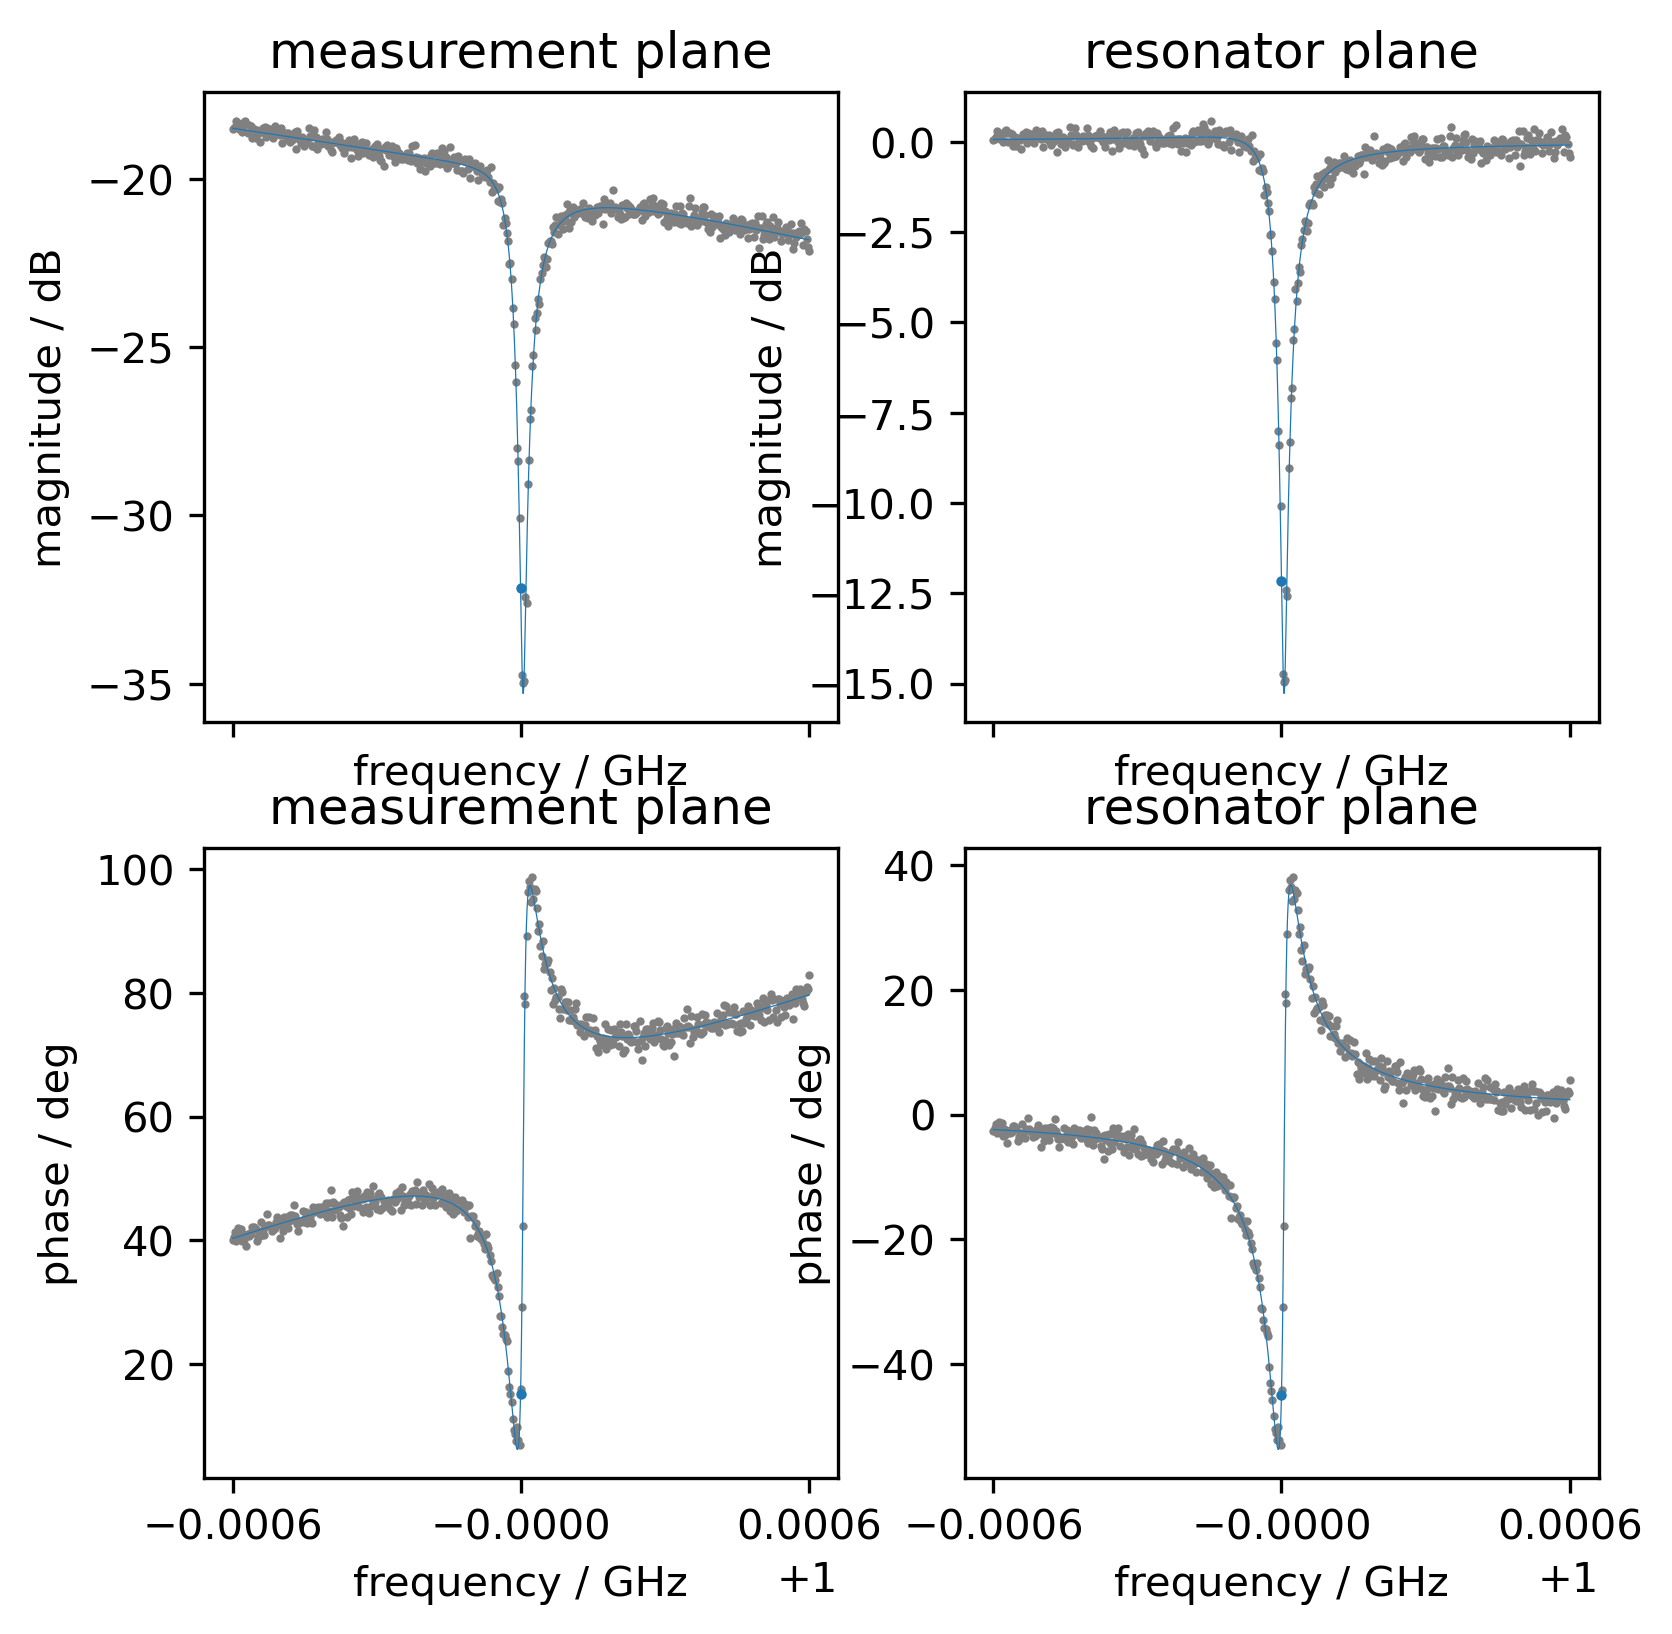

In [7]:
fig, axes = plt.subplots(2, 2, sharex='all', figsize=(6, 6), dpi=300)  # Adjust these values for your plot settings
ax_raw_mag, ax_norm_mag, ax_raw_phase, ax_norm_phase = axes.flatten()
ax_raw_mag.set_title('measurement plane')
ax_norm_mag.set_title('resonator plane')
ax_raw_phase.set_title('measurement plane')
ax_norm_phase.set_title('resonator plane')
see.magnitude_vs_frequency(resonator=resonator, axes=ax_raw_mag, normalize=False, frequency_scale=1e-9)
see.magnitude_vs_frequency(resonator=resonator, axes=ax_norm_mag, normalize=True, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_raw_phase, normalize=False, frequency_scale=1e-9)
see.phase_vs_frequency(resonator=resonator, axes=ax_norm_phase, normalize=True, frequency_scale=1e-9);